<a href="https://colab.research.google.com/github/Pranavi2004/GeneExpressionAnalysis/blob/main/MajorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    recall_score,
    precision_score,
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from scipy import ndimage
import seaborn as sns

In [ ]:
Train_Data = pd.read_csv("data_set_ALL_AML_train.csv")
Test_Data = pd.read_csv("data_set_ALL_AML_independent.csv")
labels = pd.read_csv("actual.csv", index_col = 'patient')

In [ ]:
Train_Data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
#check for nulls
print(Train_Data.isna().sum().max())
print(Test_Data.isna().sum().max())

0
0


In [ ]:
# Drop columns containing 'call' in their names
cols = [col for col in Test_Data.columns if 'call' in col]
test = Test_Data.drop(cols, axis=1)  # Specify axis=1 for columns

cols = [col for col in Train_Data.columns if 'call' in col]
train = Train_Data.drop(cols, axis=1)  # Specify axis=1 for columns

In [ ]:
patients = [str(i) for i in range(1, 73, 1)]
df_all = pd.concat([train, test], axis = 1)[patients]

In [ ]:
df_all = df_all.T

In [ ]:
df_all["patient"] = pd.to_numeric(patients)
labels["cancer"]= pd.get_dummies(labels.cancer, drop_first=True)
# add the cancer column to train data

Data = pd.merge(df_all, labels, on="patient")

In [ ]:
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,7121,7122,7123,7124,7125,7126,7127,7128,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,False
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,False
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,False
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,False
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,False


In [ ]:
Data['cancer'].value_counts()

,count
cancer,
False,47
True,25


In [ ]:
#X -> matrix of independent variable
#y -> vector of dependent variable
X, y = Data.drop(columns=["cancer"]), Data["cancer"]

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,patient
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-154,-136,49,180,-257,-273,141,-123,52,878,...,540,13,1075,-45,524,249,40,-68,-1,68
68,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,617,-34,738,11,742,234,72,109,-30,69
69,-55,-44,12,129,-108,-301,-222,-133,136,320,...,318,35,241,-66,320,174,-4,176,40,70
70,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,760,-38,201,-55,348,208,0,74,-12,71


In [ ]:
y

,cancer
0,False
1,False
2,False
3,False
4,False
...,...
67,False
68,False
69,False
70,False


In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25, random_state= 0)

In [ ]:
# Convert all column names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Now scale the data
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
X_train.shape

(54, 7130)

38 features explain around 90% of the variance. From 7129 features to 38, not too bad.


<BarContainer object of 38 artists>

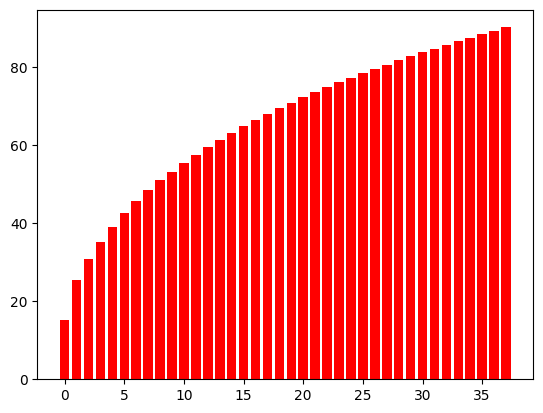

In [ ]:
pca = PCA()
pca.fit_transform(X_train)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1

print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp,color = 'r')

In [ ]:
pca.n_components_

38

<ipython-input-24-53b127b9c3c7>:11: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(10, 6))


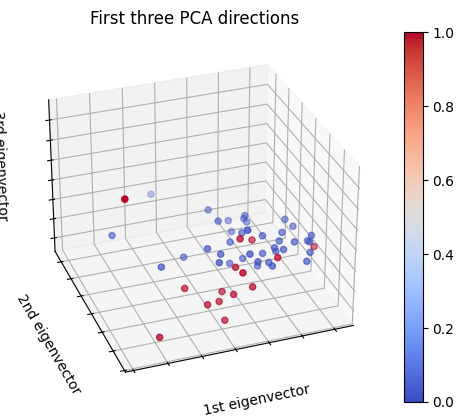

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce to 3 components
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

# Plot the reduced data
plt.clf()
fig = plt.figure(1, figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d', elev=-150, azim=110)
scatter = ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c=y_train, cmap='coolwarm', linewidths=1)
fig.colorbar(scatter, ax=ax)

# Set titles and labels
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

In [ ]:
from sklearn.utils import resample
from collections import Counter

print("Before Upsampling:-")
print(Counter(y_train))


# Let's use SMOTE to oversample
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train_pca,y_train)

print("After Upsampling:-")
print(Counter(y_train_ov))

Before Upsampling:-
Counter({False: 39, True: 15})
After Upsampling:-
Counter({False: 39, True: 39})


In [ ]:
svc_params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

search = GridSearchCV(SVC(), svc_params, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_ #to get best score
best_parameters = search.best_params_ #to get best parameters
# select best svc
best_svc = search.best_estimator_
best_svc

Fitting 5 folds for each of 40 candidates, totalling 200 fits


SVC(C=1, kernel='linear')

The accuracy of SVM is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

       False       0.62      1.00      0.76         8
        True       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



<ipython-input-27-ece0de422a30>:21: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

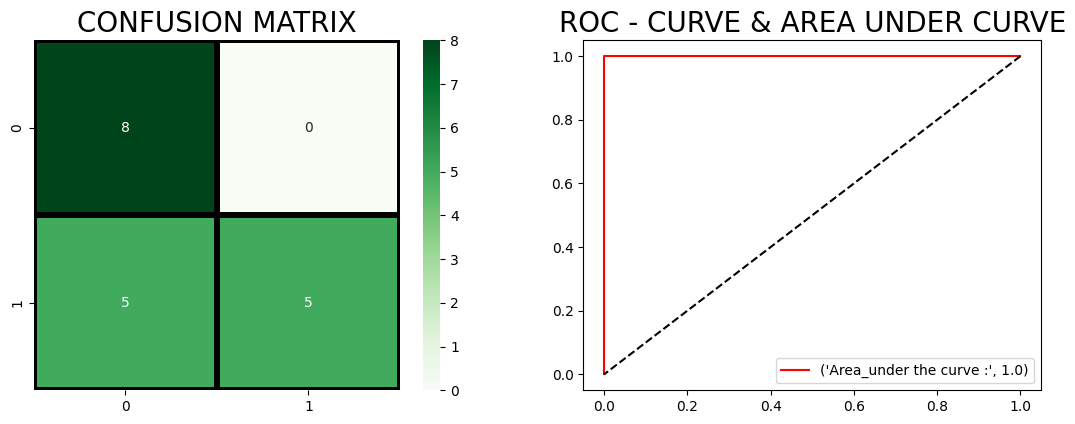

In [ ]:
svc_model = SVC(C=1, kernel='linear',probability=True)

svc_model.fit(X_train_ov, y_train_ov)

prediction=svc_model.predict(X_test_pca)

acc_svc = accuracy_score(prediction,y_test)
print('The accuracy of SVM is', acc_svc)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = svc_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [ ]:
knn_param = {
    "n_neighbors": [i for i in range(1,30,5)],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1, 10, 30],
    "p": [1,2]
}
search = GridSearchCV(KNeighborsClassifier(), knn_param, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_ #to get best score
best_parameters = search.best_params_ #to get best parameters
# select best svc
best_knn = search.best_estimator_
best_knn

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=6,
                     weights='distance')

The accuracy of K-NN is 0.6666666666666666

Classification report :
               precision    recall  f1-score   support

       False       0.60      0.75      0.67         8
        True       0.75      0.60      0.67        10

    accuracy                           0.67        18
   macro avg       0.68      0.68      0.67        18
weighted avg       0.68      0.67      0.67        18



<ipython-input-29-f72a15f228cf>:21: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

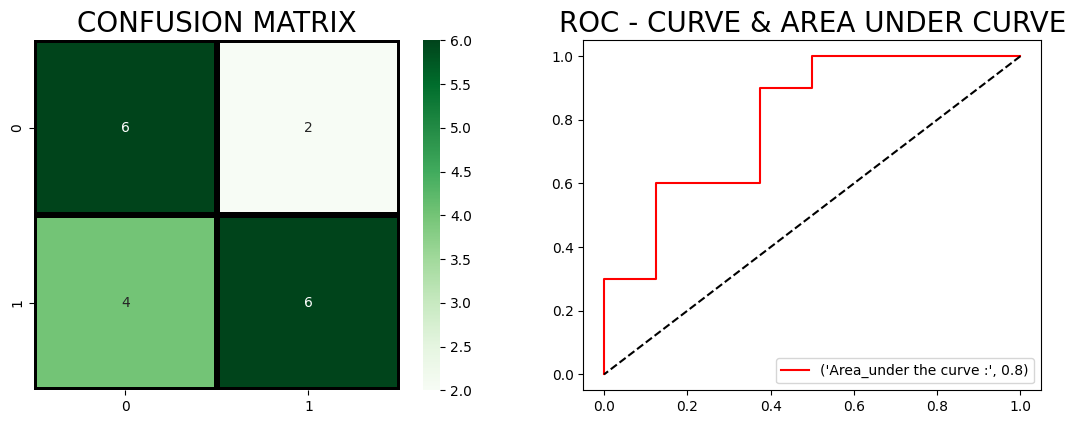

In [ ]:
knn_model = KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=6,
                     weights='distance')

knn_model.fit(X_train_ov,y_train_ov)
prediction=knn_model.predict(X_test_pca)

acc_knn = accuracy_score(prediction,y_test)
print('The accuracy of K-NN is', acc_knn)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [ ]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10],
                 'penalty': ['l1', 'l2']}

log_model = GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
                  param_grid=log_grid,
                  cv=3,
                  scoring='accuracy')
log_model.fit(X_train_ov, y_train_ov)


best_accuracy = log_model.best_score_ #to get best score
best_parameters = log_model.best_params_ #to get best parameters
# select best svc
best_lr = log_model.best_estimator_
best_lr

LogisticRegression(C=0.001, solver='liblinear')

Validation accuracy of Logistic Regression is 0.8333333333333334

Classification report :
               precision    recall  f1-score   support

       False       1.00      0.62      0.77         8
        True       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18



<ipython-input-31-7763145cd093>:21: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

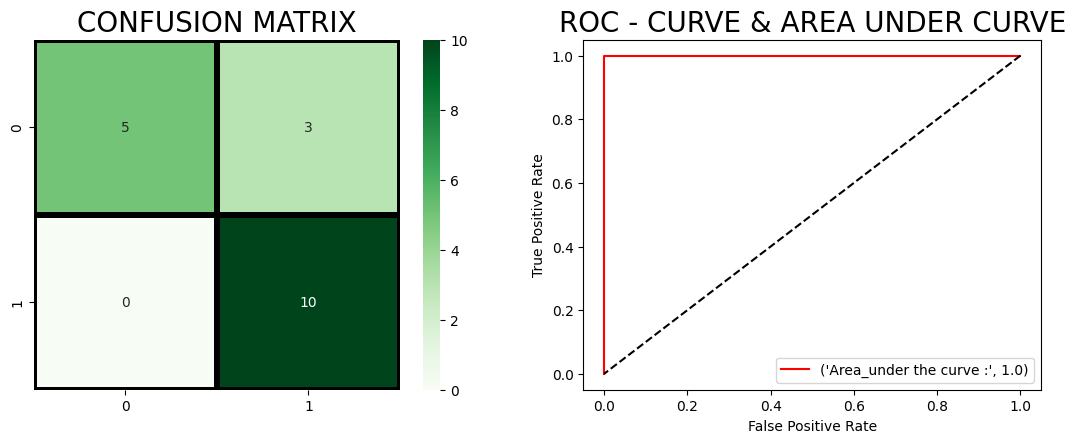

In [ ]:
lr_model = LogisticRegression(C=0.001, solver='liblinear')

lr_model.fit(X_train_ov,y_train_ov)

prediction=lr_model.predict(X_test_pca)

acc_log = accuracy_score(prediction,y_test)
print('Validation accuracy of Logistic Regression is', acc_log)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [ ]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4, 5, 6], 'max_depth':[3,4,5,6,7,8]}
decision_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

decision_search.fit(X_train_ov, y_train_ov)


best_accuracy = decision_search.best_score_ #to get best score
best_parameters = decision_search.best_params_ #to get best parameters
# select best svc
best_ds = decision_search.best_estimator_
best_ds

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4, random_state=42)

Validation accuracy of Decision Tree is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

       False       0.62      1.00      0.76         8
        True       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



<ipython-input-33-b3ff88be5e34>:21: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

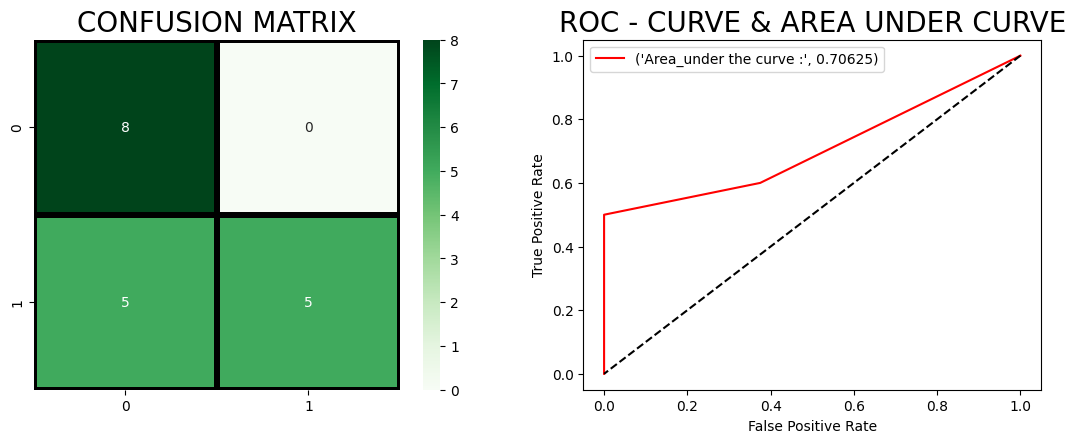

In [ ]:
ds_model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3, random_state=42)

ds_model.fit(X_train_ov,y_train_ov)

prediction=ds_model.predict(X_test_pca)

acc_decision_tree = accuracy_score(prediction,y_test)
print('Validation accuracy of Decision Tree is', acc_decision_tree)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [ ]:
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Create the GridSearchCV object
rf_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, cv=3, scoring='accuracy')
rf_search.fit(X_train_ov, y_train_ov)

best_accuracy = rf_search.best_score_ #to get best score
best_parameters = rf_search.best_params_ #to get best parameters
# select best svc
best_rf = rf_search.best_estimator_
best_rf

RandomForestClassifier(max_features=0.6, min_samples_leaf=8,
                       min_samples_split=5, n_estimators=60)

Validation accuracy of RandomForest Classifier is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

       False       0.62      1.00      0.76         8
        True       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



<ipython-input-35-1656451b01ab>:22: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

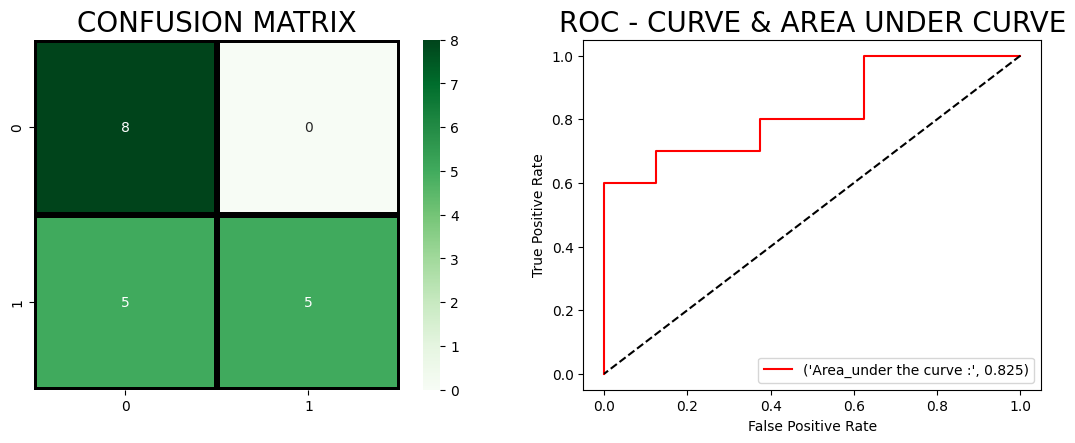

In [ ]:
rf_model = RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=70)

rf_model.fit(X_train_ov,y_train_ov)

prediction=rf_model.predict(X_test_pca)

acc_random_forest = accuracy_score(prediction,y_test)
print('Validation accuracy of RandomForest Classifier is', acc_random_forest)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = rf_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [ ]:
xgb_grid_params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
               'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
               'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
               'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

# Create the GridSearchCV object
xgb_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_grid_params, cv=3, scoring='accuracy')
xgb_search.fit(X_train_ov, y_train_ov)

best_accuracy = xgb_search.best_score_ #to get best score
best_parameters = xgb_search.best_params_ #to get best parameters
# select best svc
best_xgb = xgb_search.best_estimator_
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Validation accuracy of XG Boost is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

       False       0.62      1.00      0.76         8
        True       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:29:00] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
<ipython-input-37-3c111ef426ef>:26: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

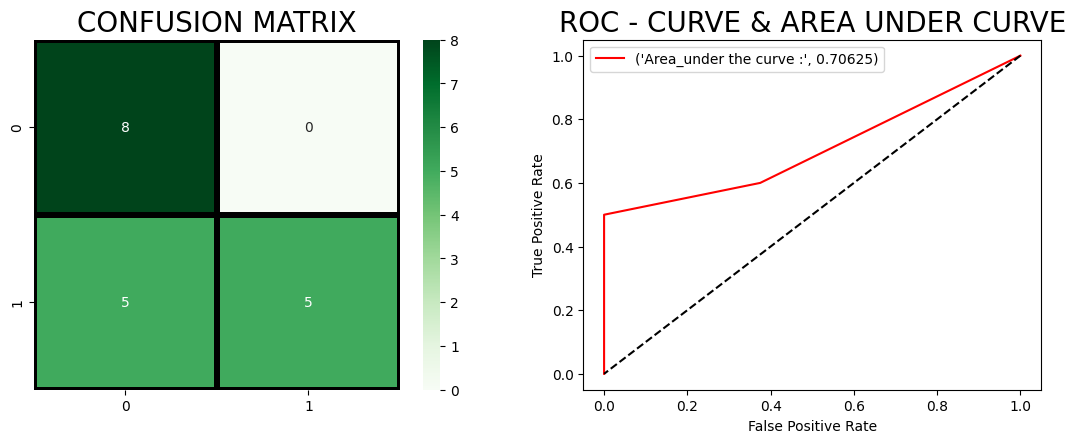

In [ ]:
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb_model.fit(X_train_ov,y_train_ov)

prediction=xgb_model.predict(X_test_pca)

acc_xgb = accuracy_score(prediction,y_test)
print('Validation accuracy of XG Boost is', acc_xgb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
predicting_probabilites = xgb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Naive Bayes is 0.8888888888888888

Classification report :
               precision    recall  f1-score   support

       False       0.88      0.88      0.88         8
        True       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



<ipython-input-38-5bdcceb0d050>:23: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

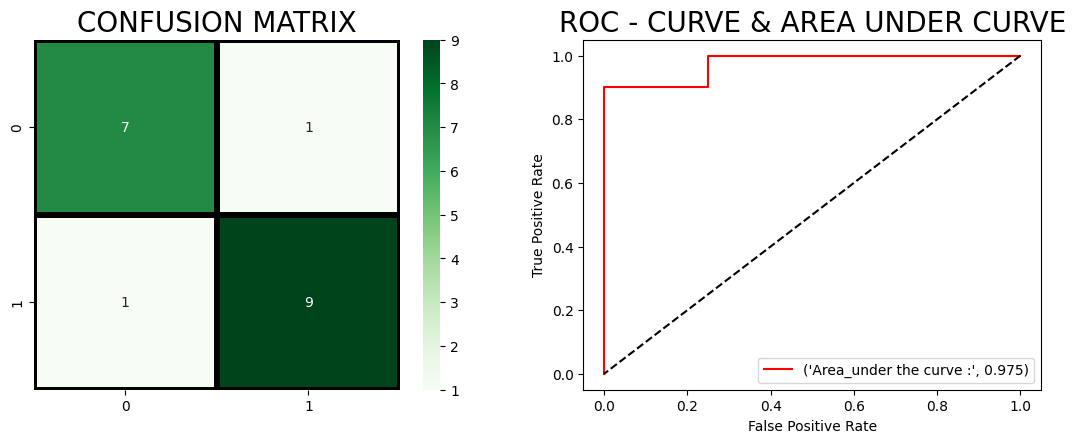

In [ ]:
from sklearn.naive_bayes import GaussianNB
#In case of naive Bayes, there isn't a hyper-parameter to tune, so you have nothing to grid search over.
nb_model = GaussianNB()

nb_model.fit(X_train_ov,y_train_ov)

prediction=nb_model.predict(X_test_pca)

acc_nb = accuracy_score(prediction,y_test)
print('Validation accuracy of Naive Bayes is', acc_nb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = nb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree',
              'Random Forest', 'XG Boost', 'Naive Bayes'],

    'Score': [acc_svc, acc_knn, acc_log, acc_decision_tree,
              acc_random_forest, acc_xgb, acc_nb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,Naive Bayes,0.888889
2,Logistic Regression,0.833333
0,Support Vector Machines,0.722222
3,Decision Tree,0.722222
4,Random Forest,0.722222
5,XG Boost,0.722222
1,KNN,0.666667


In [ ]:
Train_Data = pd.read_csv("data_set_ALL_AML_train.csv")
Test_Data = pd.read_csv("data_set_ALL_AML_independent.csv")
labels = pd.read_csv("actual.csv", index_col='patient')

In [ ]:
# Check for null values
print(Train_Data.isna().sum().max())
print(Test_Data.isna().sum().max())

# Drop 'call' columns
cols = [col for col in Test_Data.columns if 'call' in col]
test = Test_Data.drop(cols, axis=1)
cols = [col for col in Train_Data.columns if 'call' in col]
train = Train_Data.drop(cols, axis=1)

# Prepare patient data
patients = [str(i) for i in range(1, 73, 1)]
df_all = pd.concat([train, test], axis=1)[patients]
df_all = df_all.T
df_all["patient"] = pd.to_numeric(patients)
labels["cancer"] = pd.get_dummies(labels.cancer, drop_first=True)

# Merge train data with labels
Data = pd.merge(df_all, labels, on="patient")

# Split into X (features) and y (target variable)
X, y = Data.drop(columns=["cancer"]), Data["cancer"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Select numerical columns only for scaling
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)
# Check the result
print(X_train_scaled.shape)
print(X_test_scaled.shape)

0
0
(54, 7130)
(18, 7130)


In [ ]:
from sklearn.ensemble import VotingClassifier


In [ ]:
noise_factor = 0.1
X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)

# Define individual models
svc_model = SVC(C=0.01, kernel='rbf', probability=True)  # Increase regularization
knn_model = KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=6, weights='distance')
lr_model = LogisticRegression(C=0.01, solver='liblinear')
ds_model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_leaf=15, bootstrap=True)
xgb_model = xgb.XGBClassifier(learning_rate=0.001, max_depth=3, n_estimators=40, random_state=0)
nb_model = GaussianNB()

# Create an ensemble model using Voting Classifier

ensemble_model = VotingClassifier(estimators=[
    ('svc', svc_model),
    ('knn', knn_model),
    ('lr', lr_model),
    ('dt', ds_model),
    ('rf', rf_model),
    ('nb', nb_model)
], voting='hard')


# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_ov, y_train_ov = smote.fit_resample(X_train_scaled, y_train)

# Train the ensemble model
ensemble_model.fit(X_train_ov, y_train_ov)

# Make predictions on the test set
predictions = ensemble_model.predict(X_test_scaled)

# Evaluate the model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Accuracy: 0.9444
Confusion Matrix:
[[8 0]
 [1 9]]
Classification Report:
              precision    recall  f1-score   support

       False       0.89      1.00      0.94         8
        True       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18

